# TF-IDF Evaluation

In [1]:
%load_ext autoreload
%autoreload 2
import json
from gensim.summarization.bm25 import BM25
from gensim.models.phrases import Phrases, Phraser
import pandas as pd
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 1000)
import numpy as np
from multiprocessing import Pool
from functools import partial
import matplotlib.pyplot as plt
import spacy
import seaborn as sns
sns.set()


from tqdm.notebook import tqdm
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    tqdm.pandas()

import sys
import logging
logging.basicConfig(level=logging.INFO, stream=sys.stdout)


from tfidf_retrieval import TfidfRetrieval
from evaluation import *
from preprocessing import apply_pipeline, Corpus, BasicPreprocessing, BigramPreprocessor, SpacyPreprocessor

#### Load corpus using different preprocessing pipelines

In [2]:
base_file =  "../data/kit_expert_2017_papers.csv"

p = [BasicPreprocessing()]
papers_basic = Corpus(base_file, p)

p = [BasicPreprocessing(), SpacyPreprocessor(lemmatization="all")]
papers_basic_lemmatization_all = Corpus(base_file, p, load_from_cache=True)

p = [BasicPreprocessing(), SpacyPreprocessor(lemmatization="nouns")]
papers_basic_lemmatization_nouns = Corpus(base_file, p, load_from_cache=True)

INFO:preprocessing.pipeline:Start preprocessing pipeline "basic" for file ../data/kit_expert_2017_papers.csv.
INFO:preprocessing.pipeline:Loaded cached preprocessed corpus from ../data/kit_expert_2017_papers_basic
INFO:preprocessing.pipeline:Start preprocessing pipeline "basic_spacy_lemmatization_all" for file ../data/kit_expert_2017_papers.csv.
INFO:preprocessing.pipeline:Loaded cached preprocessed corpus from ../data/kit_expert_2017_papers_basic_spacy_lemmatization_all
INFO:preprocessing.pipeline:Start preprocessing pipeline "basic_spacy_lemmatization_nouns" for file ../data/kit_expert_2017_papers.csv.
INFO:preprocessing.pipeline:Start stage "basic"








INFO:preprocessing.pipeline:Finished stage "basic" in 2.42 seconds
INFO:preprocessing.pipeline:Start stage "spacy_lemmatization_nouns"










INFO:preprocessing.pipeline:Finished stage "spacy_lemmatization_nouns" in 242.51 seconds
INFO:preprocessing.pipeline:Finished preprocessing pipeline. Saved preprocessed corpus to cache file ../data/kit_expert_2017_papers_basic_spacy_lemmatization_nouns


#### Load keywords to use as test data

In [3]:
with open("../data/kit_expert_2017_keywords.json", "r") as file:
    keywords = json.load(file)

In [7]:
general_keywords = ("general keywords", [k for k in keywords if k["level"]<=1])
specific_keywords = ("specific_keywords", [k for k in keywords if k["level"]>=2][:5000])

#### Test simple tf-idf models on unigrams

In [8]:
unigram_tfidf_models = [
    ("tf linear", partial(TfidfRetrieval, corpus = papers_basic, max_ngram=1, use_idf=False, sublinear_tf=False)),
    ("tf sublinear", partial(TfidfRetrieval, corpus = papers_basic, max_ngram=1, use_idf=False, sublinear_tf=True)),
    ("tf-idf linear", partial(TfidfRetrieval, corpus = papers_basic, max_ngram=1, use_idf=True, sublinear_tf=False)),
    ("tf-idf sublinear", partial(TfidfRetrieval, corpus = papers_basic, max_ngram=1, use_idf=True, sublinear_tf=True)),
]

In [9]:
unigram_tfidf_results = train_evaluate_models(unigram_tfidf_models, [general_keywords, specific_keywords], n_jobs=4)

In [10]:
print("mAP scores for unigram tfidf models:")
unigram_tfidf_results

mAP scores for unigram tfidf models:


,general keywords,specific_keywords
tf linear,0.048705,0.315517
tf sublinear,0.054267,0.411899
tf-idf linear,0.049875,0.384793
tf-idf sublinear,0.051161,0.457455


Results:
- Performs very bad on general keywords
- Performs ok on specific keywords
- Use of inverse document frequency improves result 
- Use of sublinear scaling of term frequency improves results 

#### Test tf-idf models on n-grams

In [11]:
ngram_tfidf_models = [
    ("tf-idf sublinear 2-gram", partial(TfidfRetrieval, corpus=papers_basic, max_ngram=2, use_idf=True, sublinear_tf=True)),
    ("tf-idf sublinear 3-gram", partial(TfidfRetrieval, corpus=papers_basic, max_ngram=3, use_idf=True, sublinear_tf=True)),
    ("tf-idf sublinear 4-gram", partial(TfidfRetrieval, corpus=papers_basic, max_ngram=4, use_idf=True, sublinear_tf=True)),
]

In [ ]:
ngram_tfidf_results = train_evaluate_models(ngram_tfidf_models, [general_keywords, specific_keywords], n_jobs=5)

In [ ]:
print("mAP scores for ngram tfidf models:")
ngram_tfidf_results

Results:
- No significant change for general keywords
- Bigrams provide great improvement for specific keywords
- 3 and 4-grams do not lead to significant further improvements

In [ ]:
lemmatization_tfidf_models = [
    ("tf-idf 1-gram lematization all", partial(TfidfRetrieval, corpus = papers_basic_lemmatization_all, max_ngram=1, use_idf=True, sublinear_tf=True)),
    ("tf-idf 1-gram lematization nouns", partial(TfidfRetrieval, corpus = papers_basic_lemmatization_nouns, max_ngram=1, use_idf=True, sublinear_tf=True)),
    ("tf-idf 2-gram lematization all", partial(TfidfRetrieval, corpus = papers_basic_lemmatization_all, max_ngram=2, use_idf=True, sublinear_tf=True)),
    ("tf-idf 2-gram lematization nouns", partial(TfidfRetrieval, corpus = papers_basic_lemmatization_nouns, max_ngram=2, use_idf=True, sublinear_tf=True)),
]

In [ ]:
lemmatization_tfidf_results = train_evaluate_models(lemmatization_tfidf_models, [general_keywords, specific_keywords], n_jobs=4)

In [ ]:
print("mAP scores for lemmatization tfidf models:")
lemmatization_tfidf_results

#### Grid search for BM25 k1 parameter

In [42]:
k1_grid = np.arange(0.1,1.5,0.1)
search_k1_bm25_models = [(f"BM25 k1={k1:.2f}", partial(TfidfRetrieval, corpus=papers_basic, use_bm25=True, k1=k1)) for k1 in k1_grid]

In [ ]:
%%time
search_k1_bm25_results = train_evaluate_models(search_k1_bm25_models, [general_keywords, specific_keywords], n_jobs=len(search_k1_bm25_models))

In [14]:
print("mAP scores for bm25 k1 search models:")
search_k1_bm25_results

mAP scores for bm25 k1 search models:


,general keywords,specific_keywords
BM25 k1=0.10,0.054976,0.534623
BM25 k1=0.20,0.055168,0.535226
BM25 k1=0.30,0.055318,0.533408
BM25 k1=0.40,0.055461,0.530193
BM25 k1=0.50,0.055592,0.526211
BM25 k1=0.60,0.055640,0.523617
BM25 k1=0.70,0.055747,0.519903
BM25 k1=0.80,0.055788,0.514663
BM25 k1=0.90,0.055874,0.510322
BM25 k1=1.00,0.055978,0.506207


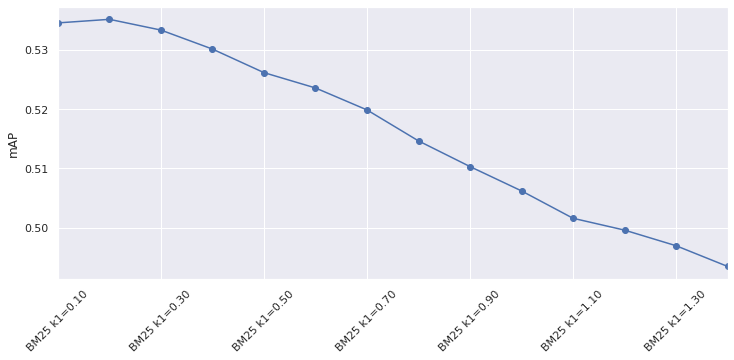

In [44]:
ax = search_k1_bm25_results["specific_keywords"].plot(figsize=(12,5), style="-bo", rot=45, legend=False)
ax.set_ylabel("mAP");

Results:
- k1 of 0.2 has the best performance

#### Grid search for BM25 b parameter

In [16]:
b_grid = np.arange(0.1,1.1,0.1)
search_b_bm25_models = [(f"BM25 b={b:.2f}", partial(TfidfRetrieval, corpus=papers_basic, use_bm25=True, b=b, k1=0.2)) for b in b_grid]

In [ ]:
%%time
search_b_bm25_results = train_evaluate_models(search_b_bm25_models, [general_keywords, specific_keywords], n_jobs=len(search_b_bm25_models))

In [22]:
print("mAP scores for bm25 b search models:")
search_b_bm25_results

mAP scores for bm25 b search models:


,general keywords,specific_keywords
BM25 b=0.10,0.054874,0.527841
BM25 b=0.20,0.055107,0.528939
BM25 b=0.30,0.055184,0.531163
BM25 b=0.40,0.055502,0.532409
BM25 b=0.50,0.055383,0.534166
BM25 b=0.60,0.055352,0.533565
BM25 b=0.70,0.055046,0.535282
BM25 b=0.80,0.055030,0.534848
BM25 b=0.90,0.055027,0.532954
BM25 b=1.00,0.053787,0.532048


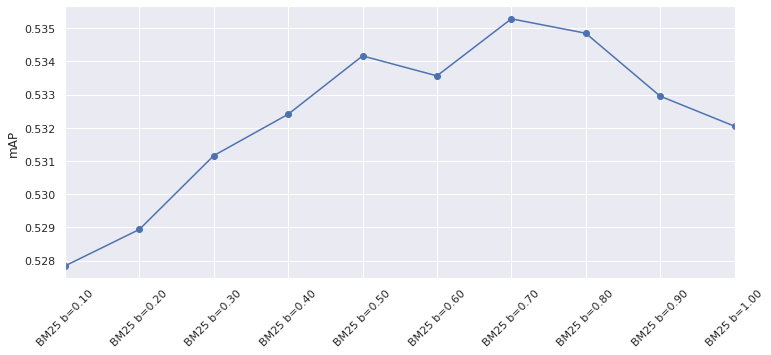

In [45]:
ax = search_b_bm25_results["specific_keywords"].plot(figsize=(12,5), style="-bo", rot=45, legend=False)
ax.set_ylabel("mAP");

Results:
- b parameter does not have a great effect on model performance
- best value at 0.7

#### Test bm25 with best parameters on n-grams

In [11]:
ngram_bm25_models = [
    ("bm25 2-gram", partial(TfidfRetrieval, corpus=papers_basic, max_ngram=2, use_bm25=True, k1=0.2, b=0.7)),
    ("bm25 3-gram", partial(TfidfRetrieval, corpus=papers_basic, max_ngram=3, use_bm25=True, k1=0.2, b=0.7)),
]

In [14]:
ngram_bm25_results = train_evaluate_models(ngram_bm25_models, [general_keywords, specific_keywords])

1477712



CPU times: user 3.71 s, sys: 1.76 s, total: 5.47 s
Wall time: 13min 44s


In [15]:
print("mAP scores for ngram bm25 models:")
ngram_bm25_results

mAP scores for ngram bm25 models:


,general keywords,specific_keywords
bm25 2-gram,0.054687,0.622511


Results:
- bigrams improve result of bm25
- bm25 bigram model achieves best score on specific keywords
- general keyword score still very low

In [16]:
from query_expansion_retrieval import QueryExpansionRetrieval

In [17]:
with open("../data/keyword_hierarchy.json", 'r') as file:
    keyword_hierarchy = json.load(file)

In [18]:
bm25_model_unigram = TfidfRetrieval(corpus=papers_basic, max_ngram=1, use_bm25=True, k1=0.2, b=0.7)
bm25_model_bigram = TfidfRetrieval(corpus=papers_basic, max_ngram=2, use_bm25=True, k1=0.2, b=0.7)

79896
1477712


In [ ]:
query_expansion_models = [
    ("qe unigram expand all", 
     partial(QueryExpansionRetrieval, 
             wrapped_model=bm25_model_unigram, 
             expansion_hierarchy=keyword_hierarchy,
             only_expand_once=False,
             separate_weighting=False)),
    ("qe unigram expand first"
     partial(QueryExpansionRetrieval, 
             wrapped_model=bm25_model_unigram, 
             expansion_hierarchy=keyword_hierarchy,
             only_expand_once=True,
             separate_weighting=False)),
    ("qe bigram expand all", 
     partial(QueryExpansionRetrieval, 
             wrapped_model=bm25_model_bigram,
             expansion_hierarchy=keyword_hierarchy,
             only_expand_once=False,
             separate_weighting=False)),
    ("qe bigram expand first"
     partial(QueryExpansionRetrieval, 
             wrapped_model=bm25_model_bigram, 
             expansion_hierarchy=keyword_hierarchy,
             only_expand_once=True,
             separate_weighting=False)),
    ("qe unigram expand all separate weighting"
     partial(QueryExpansionRetrieval, 
             wrapped_model=bm25_model_unigram, 
             expansion_hierarchy=keyword_hierarchy,
             only_expand_once=False,
             separate_weighting=True)),
    ("qe unigram expand first separate weighting"
     partial(QueryExpansionRetrieval, 
             wrapped_model=bm25_model_unigram, 
             expansion_hierarchy=keyword_hierarchy,
             only_expand_once=True,
             separate_weighting=True))
]

In [ ]:
query_expansion_results = train_evaluate_models(query_expansion_results, [general_keywords, specific_keywords])

In [ ]:
print("mAP scores for query expansion models:")
ngram_bm25_result